# Autoencoders

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./include')

%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
%pip install git+https://github.com/agdelma/ml4s.git#egg=ml4s

import ml4s
ml4s.set_css_style('./include/bootstrap.css')

  Cloning https://github.com/agdelma/ml4s.git to /private/var/folders/7h/n8nd5yq95679t4llv_wkmc3m0000gn/T/pip-install-w8apv8ub/ml4s_e4a28fd65ffe40c28a0fd2a259b9109c
  Running command git clone --filter=blob:none --quiet https://github.com/agdelma/ml4s.git /private/var/folders/7h/n8nd5yq95679t4llv_wkmc3m0000gn/T/pip-install-w8apv8ub/ml4s_e4a28fd65ffe40c28a0fd2a259b9109c
  Resolved https://github.com/agdelma/ml4s.git to commit b3e9dc6b5ffe9d01399e56fd73c6792fe6d57f50
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


## Previously

- Principal Component Analysis
- Identifying the low-dimensional latent space which maximally explains the *variance* of the data
- Implementing PCA by hand and with `sklearn`

## Now

- Connection between PCA and autoencoders, a compressive deep neural network architecture
- Application of PCA for clustering

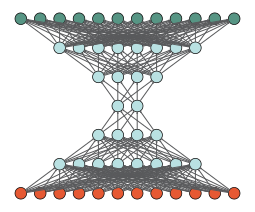

In [3]:
ml4s.draw_network([12,8,4,2,4,8,12],annotate=False )

## Principal Component Analysis (PCA)

Recall that for a given set of unlabelled data $\{ \boldsymbol{x}^{(n)} \}_{n=1}^{N}$ our goal is to project the data onto a latent space having dimensionality $M < D$.  We did this by performing a spectral decomposition of the covariance matrix

\begin{equation}
\Sigma(\mathbf{X}) = \frac{1}{N-1} \mathbf{X}^{\top}\mathbf{X}
\end{equation}

where $\mathbf{X}$ is the  data design matrix: 

\begin{equation}
\mathbf{X} = \left( \begin{array}{cccc}
        x_{1}^{(1)} & x_{2}^{(1)} & \cdots & x_{D}^{(1)} \\
\vdots        &      \vdots    & \ddots & \vdots \\
        x_{1}^{(N)} & x_{2}^{(N)} & \cdots & x_{D}^{(N)} \\
\end{array}
\right)\, .
\end{equation}

We determined:

\begin{equation}
\boldsymbol{V}^\top \Sigma(\mathbf{X}) \boldsymbol{V} = \Lambda
\end{equation}

where $\Lambda_{ij} = \lambda_i \delta_{ij}$ is the diagonal matrix of principle components and the PCA vectors are encoded as the columns of the orthogonal matrix $\boldsymbol{V}$.

Also recall the *percentage of the explained variance* defined:

\begin{equation}
\text{PCA-j} = \frac{\lambda_j}{\sum_{j=1}^{D} \lambda_j}
\end{equation}

and the projector:

\begin{equation}
\boldsymbol{P} = \sum_{j=1}^M\boldsymbol{v}_j\boldsymbol{v}_j^\mathsf{T}\, .
\end{equation}


## Neural Networks and Linear Autoencoders

There is a very nice way to interpret PCA as a type of *linear autoencoder* whereby one trains a neural network with a hidden layer (with linear activation) that acts as an **information bottleneck.**  We want to minimize the least squred error between input and output. The network calculates:

\begin{equation}
\boldsymbol{P} \mathbf{x}^{(n)}
\end{equation}

for each $\mathbf{x}_n$ and we minimize the cost:

\begin{equation}
\mathcal{C} = \left \langle \mathbf{x}^{(n) \top}  \mathbf{x}^{(n)} - \mathbf{x}^{(n)\top} \boldsymbol{P}\mathbf{x}^{(n)} \right \rangle  = \frac{1}{N} \sum_{n=1}^{N}\left( \mathbf{x}^{(n) \top} \mathbf{x}^{(n)} - \mathbf{x}^{(n) \top} \boldsymbol{P}\mathbf{x}^{(n)} \right) \, .
\end{equation}

To obtain the 1st princpal component for our example above we consider the linear autoencoder.

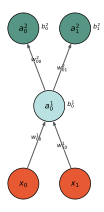

In [4]:
ml4s.draw_network([2,1,2])

In [5]:
import torch
import torch.nn as nn

### Create a simple linear autoencoder in `pytorch`

In [6]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.hidden = None

    def forward(self, x):
        self.hidden = self.encoder(x)
        x = self.decoder(self.hidden)
        return x

### Set some hyperparameters

In [7]:
input_dim = 2
latent_dim = 1
learning_rate = 0.001
num_epochs = 100
batch_size = 32

### Load the data set

In [8]:
x = np.loadtxt('./data/scatter_2d_pca.dat').astype(np.float32)
dataset = torch.tensor(x)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### Setup the model

In [11]:
# Model Initialization
model = LinearAutoencoder(input_dim, latent_dim)

# Validation using MSE Loss function
criterion = nn.MSELoss()

# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

### Model Training

In [12]:
losses = []
for epoch in range(num_epochs):
    for batch in train_loader:
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

Epoch [10/100], Loss: 0.1276
Epoch [20/100], Loss: 0.0880
Epoch [30/100], Loss: 0.0536
Epoch [40/100], Loss: 0.0695
Epoch [50/100], Loss: 0.0567
Epoch [60/100], Loss: 0.0488
Epoch [70/100], Loss: 0.0532
Epoch [80/100], Loss: 0.0357
Epoch [90/100], Loss: 0.0377
Epoch [100/100], Loss: 0.0760
Training complete


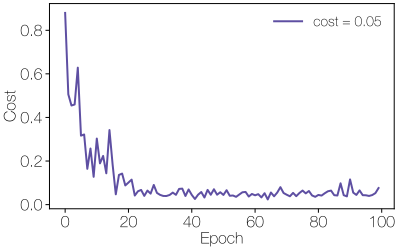

In [14]:
# Evaluate the model
with torch.no_grad():
    outputs = model(dataset)
    final_loss = criterion(outputs, dataset)
    
    plt.plot(losses,color=colors[0], linestyle='-',label=f'cost = {final_loss.item():.2f}')
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.legend()

### Extract the trained weights and biases from the model

The weights are in the format [`decoder_weight, decoder_bias, encoder_weight, encoder_bias]`


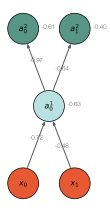

In [15]:
weights = [param.detach().numpy() for param in model.parameters()]
ml4s.draw_network([input_dim,latent_dim,input_dim], weights=[weights[0],weights[2]], 
                           biases=[weights[1],weights[3]])

### Plot the raw data with the learned decoder weight

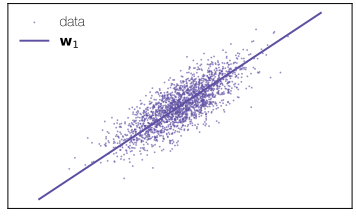

In [16]:
plt.scatter(x[:,0], x[:,1], s=1, alpha=0.5, label='data')
_x = np.linspace(-4, 4, 100)

decoder_weight = weights[2]
plt.plot(_x, decoder_weight[1, 0] / decoder_weight[0, 0] * _x, '-', color=colors[0], label=r'$\mathbf{w}_1$')

plt.axis('equal')
plt.xticks([])
plt.yticks([]);
plt.legend()

### Can you get more principal components with this strategy? 

Unlike the eigenvector problem we solved for PCA, the issue is that there is no guarentee the components will be orthognoal.  See:

[E. Plaut, From Principal Subspaces to Principal Components with Linear Autoencoders, arXiv:1804.10253 (2018)](https://arxiv.org/abs/1804.10253)

for a discussion of how you can re-orthogonalize via a singular value decomposition of the weight matrix.

### Let's see what happens

In [17]:
# Model Initialization
latent_dim = 2
model = LinearAutoencoder(input_dim, latent_dim)

# Validation using MSE Loss function
criterion = nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [18]:
losses = []
for epoch in range(num_epochs):
    for batch in train_loader:
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

Epoch [10/100], Loss: 0.0836
Epoch [20/100], Loss: 0.0233
Epoch [30/100], Loss: 0.0020
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
Training complete


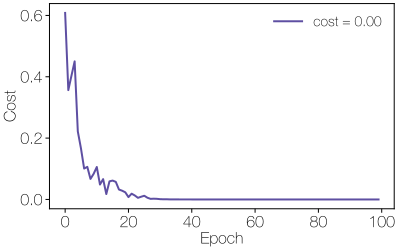

In [19]:
# Evaluate the model
with torch.no_grad():
    outputs = model(dataset)
    final_loss = criterion(outputs, dataset)

plt.plot(losses,color=colors[0], linestyle='-',label=f'cost = {final_loss.item():.2f}')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.legend()

### Plot the final weights

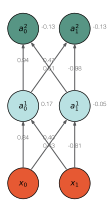

In [20]:
weights = [param.detach().numpy() for param in model.parameters()]
decoder_weight = weights[2]

ml4s.draw_network([input_dim,latent_dim,input_dim], weights=[weights[0],weights[2]], 
                           biases=[weights[1],weights[3]])

### Plot the data with the learned (non-orghgonal) latent space

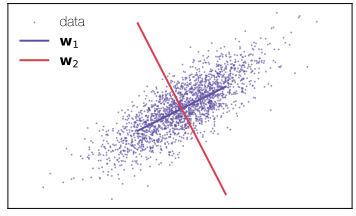

In [22]:
fig,ax = plt.subplots()
ax.scatter(x[:,0],x[:,1], s=1, alpha=0.5,label='data')
_x = np.linspace(-1,1,100)

ax.plot(_x,decoder_weight[1, 0] / decoder_weight[0, 0] * _x, '-', color=colors[0], label=r'$\mathbf{w}_1$')
ax.plot(_x,decoder_weight[1, 1] / decoder_weight[0, 1] * _x, '-', color=colors[-2], label=r'$\mathbf{w}_2$')

ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

<div class="span alert alert-success">
<h2>Use Case: Detecting a Phase Transition in the 2D Ising Model </h2>

In a recent <a href="https://journals.aps.org/pre/abstract/10.1103/PhysRevE.107.054104" title="Group-equivariant autoencoder for identifying spontaneously broken symmetries">paper</a> we used a group-equivariant autoencoder for identifying a phase transition. In this exercise you will confirm our analysis.
    
1. Load Ising model configurations from disk.
</div>

## Load the data from disk

We have a $2000$ Ising model configurations for a $80 \times 80$ square lattice at various temperatures obtained via Monte Carlo sampling.  Without the temperature information we can think of this as unlabeled data.

In [23]:
L = 80
configs = np.loadtxt(f'./data/Ising2D_config_L{L}.dat.gz')
temps = np.loadtxt(f'./data/Ising2D_temps_L{L}.dat')

### Plot a random configuration

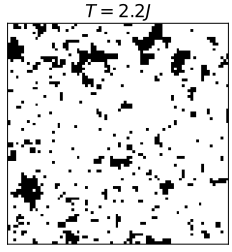

In [24]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))

idx = np.random.randint(low=0,high=configs.shape[0]+1)
img = ax.matshow(configs[idx].reshape(L,L), cmap='binary')
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(f'$T = {temps[idx]:.1f}J$');

### Define a non-linear autoencoder 

In [25]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim,latent_dim),
            nn.LeakyReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim,input_dim)
        )
        self.hidden = None

    def forward(self, x):
        self.hidden = self.encoder(x)
        x = self.decoder(self.hidden)
        return x

### Hyperparameters

In [46]:
input_dim = configs.shape[1]
hidden_dim = 32
latent_dim = 2
learning_rate = 1e-5
num_epochs = 200
batch_size = 32

#### Create the dataloader

In [47]:
dataset = torch.tensor(configs.astype(np.float32))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
# Model Initialization
model = Autoencoder(input_dim,hidden_dim,latent_dim)

# Validation using MSE Loss function
criterion = nn.MSELoss()

# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay = 1e-8)

In [49]:
losses = []
for epoch in range(num_epochs):
    for batch in train_loader:
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

Epoch [10/200], Loss: 1.0248
Epoch [20/200], Loss: 1.0200
Epoch [30/200], Loss: 0.9733
Epoch [40/200], Loss: 0.8401
Epoch [50/200], Loss: 0.7039
Epoch [60/200], Loss: 0.5491
Epoch [70/200], Loss: 0.5375
Epoch [80/200], Loss: 0.4946
Epoch [90/200], Loss: 0.4265
Epoch [100/200], Loss: 0.3817
Epoch [110/200], Loss: 0.2408
Epoch [120/200], Loss: 0.5527
Epoch [130/200], Loss: 0.6171
Epoch [140/200], Loss: 0.4469
Epoch [150/200], Loss: 0.4193
Epoch [160/200], Loss: 0.4043
Epoch [170/200], Loss: 0.2933
Epoch [180/200], Loss: 0.4963
Epoch [190/200], Loss: 0.2941
Epoch [200/200], Loss: 0.2570
Training complete


### Investigate the training history

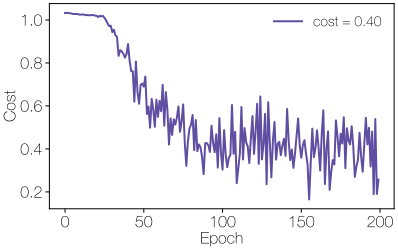

In [50]:
# Evaluate the model
with torch.no_grad():
    outputs = model(dataset)
    final_loss = criterion(outputs, dataset)
    
plt.plot(losses,color=colors[0], linestyle='-',label=f'cost = {final_loss.item():.2f}')
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.legend()

### Plot the latent-space

Text(0.5, 0, '$latent-1$')

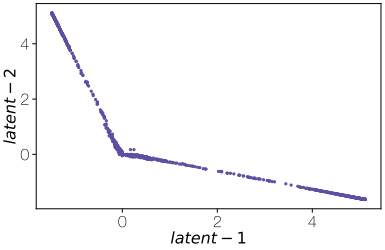

In [51]:
with torch.no_grad():
    latent_x = model.hidden.numpy()
    
fig,ax = plt.subplots(1)
ax.scatter(latent_x[:,0],latent_x[:,1], s=5)
ax.set_ylabel(r'$latent-2$')
ax.set_xlabel(r'$latent-1$')

### We actually have labels!

We know the temperatures where each configuration was measured, so we can add temperature labels to the dat to see what the latent space is doing.

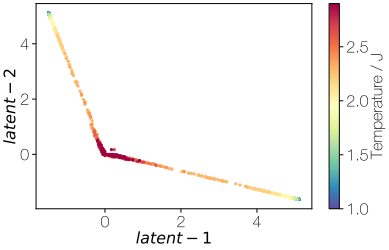

In [52]:
fig,ax = plt.subplots(1)
sc = ax.scatter(latent_x[:,0],latent_x[:,1], s=5, c=temps, cmap='Spectral_r')
ax.set_ylabel(r'$latent-2$')
ax.set_xlabel(r'$latent-1$')

fig.colorbar(sc, ax=ax, label='Temperature / J')

### Investigate what we have learned

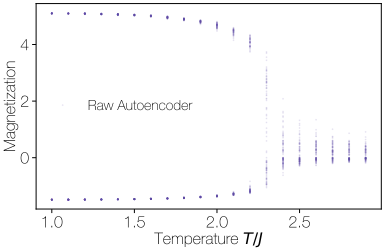

In [53]:
fig,ax = plt.subplots(1)
ax.plot(temps,latent_x[:,0], 'o', ms=1, alpha=0.1, label='Raw Autoencoder')
ax.set_xlabel('Temperature $T/J$')
ax.set_ylabel('Magnetization')
ax.legend()

<div class="span alert alert-info" role="alert">
    <h3>We have discovered something that looks like the magnetization!</h3>
</div>

However, note, there is no *physics* in our autoencoder.  We have not input the fact that the magnetization needs to be normalized to the 1. Let's do this and compare with the exact magnetization:

\begin{equation}
m=\left[1-\left(\sinh \frac{2J}{k_{\rm B}T}\right)^{-4}\right]^{\frac {1}{8}}
\end{equation}

In [54]:
def magnetization_exact_(T):
    '''We use units where J/k_B = 1.'''
    Tc = 2.0/np.log(1.0+np.sqrt(2.0))
    if T < Tc:
        return (1.0 - np.sinh(2.0/T)**(-4))**(1.0/8)
    else:
        return 0.0
magnetization_exact = np.vectorize(magnetization_exact_)

### Normalize the raw latent space values

In [57]:
latent_m = latent_x[:,0]
m = np.zeros_like(latent_m)

# find the maximum value and normalize
idx_pos = np.where(latent_m>0)
m[idx_pos] = latent_m[idx_pos]/np.max(latent_m)

# find the minimum value and normalize
idx_neg = np.where(latent_m<0)
m[idx_neg] = latent_m[idx_neg]/np.min(latent_m)

### Plot and Compare

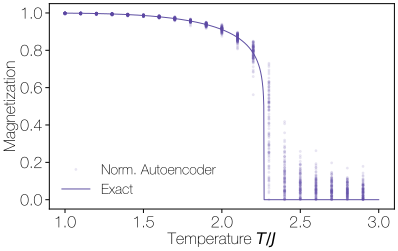

In [58]:
# plot and compare
fig,ax = plt.subplots(1)

ax.plot(temps,m, 'o', ms=2, alpha=0.1, label='Norm. Autoencoder')
_T = np.linspace(1,3,1000)
ax.plot(_T,magnetization_exact(_T), color=colors[0], zorder=-1, lw=1, label='Exact')

ax.set_xlabel('Temperature $T/J$')
ax.set_ylabel('Magnetization')

ax.legend()

<div class="span alert alert-info" role="alert">
    <h3>It Works!</h3>
</div>